In [35]:
import sys
import numpy as np


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import scipy as sp
import scipy.io as spio
import matplotlib.pylab as pl

import deconv
import dsutils

# for extractions of image patches
from sklearn.feature_extraction import image 

In [2]:
#%%  data parameters
sigma=0.01
npsf=64
nr=5
napp=100000
nval=50000

PSF=deconv.get_PSF_airy(npsf,nr)

#%% load dataset
lst_img=['M31','Hoag','M51a','M81','M101','M104']
#lst_img=['M101']
nb_img=len(lst_img)

I0_full=[deconv.load_fits_image(img) for img in lst_img]
print(I0_full[0].shape)

(3571, 3564)


In [3]:
# cropping images in 1024 by 1024 
I0_all=[np.array(img[1273:2297, 1270:2294]) for img in I0_full]
print(I0_all[0].shape)
# pre-process images (pste positive and max to 1)
I0_all=[np.maximum(0,I/I.max()) for I in I0_all]
# compute convolution
I0_all_conv=[deconv.fftconvolve(I,PSF,'same') for I in I0_all]
I_all=[I+sigma*np.random.randn(I.shape[0],I.shape[1]) for I in I0_all_conv]

mse_conv=np.array([deconv.mse(I0_all[i],I0_all_conv[i]) for i in range(nb_img)])
mse_convnoise=np.array([deconv.mse(I0_all[i],I_all[i]) for i in range(nb_img)])

(1024, 1024)


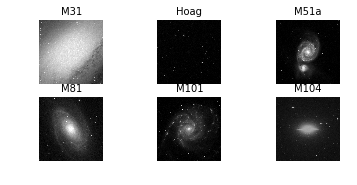

In [5]:
pl.figure(1)
pl.clf()
vmin=0.15
vmax=0.9
k=1

yt=0.99
fs=10
for i in range(6):
    pl.subplot(3,3,1+i)
    if i==5:
        k=0.7
    pl.imshow(I0_all[i]*k,cmap='gray',vmin=vmin,vmax=vmax)
    pl.title(lst_img[i],fontsize=fs,y=yt)
    pl.axis("off")
    
    
pl.savefig('imgs/images.png',dpi=200,bbox_inches='tight',pad_inches=.005)


#pl.subplots_adjust(wspace=-.1,hspace=0.12)
#pl.savefig('imgs/images.png',dpi=200,bbox_inches='tight',pad_inches=.005)

In [5]:
X_train = np.array([image.extract_patches_2d(np.pad(I_all[i], (4,4), 'mean'), (14, 14)) for i in range(1, nb_img)]) # padding array and starting from 2 image for training
X_train = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], 14, 14))
y_train = np.array([image.extract_patches_2d(I0_all[i], (6, 6)) for i in range(1, nb_img)])
y_train = np.reshape(y_train, (y_train.shape[0] * y_train.shape[1], 6, 6))
print(X_train.shape)
print(y_train.shape)

(5191805, 14, 14)
(5191805, 6, 6)


In [6]:
# Reshaping to format which CNN expects (batch, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1).astype('float32')

print(X_train.shape)
print(y_train.shape)

(5191805, 14, 14, 1)
(5191805, 6, 6, 1)
(1038361, 14, 14, 1)
(1038361, 6, 6, 1)


In [10]:
from tensorflow.python import keras
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout

# Your Code Here
model = Sequential()
model.add(Conv2D(64, kernel_size=(6, 6), input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
#model.add(Dropout(0.5))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu')) # padding = "same",
model.add(Conv2D(1, kernel_size=(2, 2), activation='relu')) # padding = "same",
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 9, 9, 64)          2368      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          9232      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 1)           65        
_________________________________________________________________
dense_1 (Dense)              (None, 6, 6, 1)           2         
Total params: 11,667
Trainable params: 11,667
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          validation_split = 0.2)

In [ ]:
X_test = np.array(np.pad(I_all[0], (4, 4), 'mean')) # padding, first image is the testing image
y_test = np.array(I0_all[0]) 
X_test = image.extract_patches_2d(X_test, (14, 14)) # padding, first image is the testing image
y_test = image.extract_patches_2d(y_test, (6, 6)) # padding, first image is the testing image

print(X_test.shape)
print(y_test.shape)
#test_patches

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1).astype('float32')
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],y_test.shape[2], 1).astype('float32')
print(X_test.shape)
print(y_test.shape)

In [9]:
# Save the model
#model.save('models/restoreCNN.h5')

# Final evaluation of the model
# metrics = model.evaluate(X_test, y_test, verbose=True)

# Producing a restored image
y_out = model.predict(X_test, verbose=1)
mse_yout = deconv.mse(y_out, y_test)

print(-10*np.log10(mse_yout))

#print("Metrics(Test loss & Test Accuracy): ")
#print(metrics)

1038361/1038361 [==============================] - 43s 41us/step
34.01318311691284


In [11]:
degImage = I_all[0]
orgImage = I0_all[0]
resImage = y_out.reshape(y_out.shape[0], y_out.shape[1], y_out.shape[2])
resImage = image.reconstruct_from_patches_2d(resImage, orgImage.shape)
#resImage = np.reshape(y_out, 256*4, 256*4)
mse_deg = deconv.mse(orgImage, degImage)
mse_res = deconv.mse(orgImage, resImage)
print(mse_deg, mse_res)
print(-10*np.log10(mse_deg), -10*np.log10(mse_res))

0.000713704683782984 0.0006236868546047201
31.46481453117767 32.05033409440604


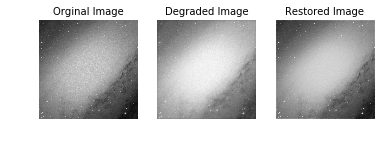

In [11]:
pl.subplot(1,3,1)
pl.imshow(orgImage, cmap='gray')
pl.title("Orginal Image",fontsize=10)
pl.axis("off")

pl.subplot(1,3,2)
pl.imshow(degImage, cmap='gray')
pl.title("Degraded Image",fontsize=10)
pl.axis("off")

pl.subplot(1,3,3)
pl.imshow(resImage, cmap='gray')
pl.title("Restored Image",fontsize=10)
pl.axis("off")

pl.savefig('imgs/results.png',dpi=200,bbox_inches='tight',pad_inches=.005)